# Under sampling method : sklearn

imblearn document : https://imbalanced-learn.org/stable/introduction.html

In [ ]:
!pip install imblearn

## Load modules

In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_CNN으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_CNN

## Define plot_representation function

데이터 시각화를 위한 함수

In [2]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna()
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]
    
    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
        X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)
        
    plt.show()

confusion matrix 시각화 함수

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    혼동 행렬을 시각화하는 함수입니다.

    인자:
    cm : numpy.ndarray
        혼동 행렬
    classes : list
        클래스 레이블의 이름을 포함하는 리스트
    normalize : bool, optional (default=False)
        True로 설정하면 혼동 행렬을 정규화합니다.
    title : str, optional (default='Confusion Matrix')
        시각화의 제목
    cmap : matplotlib colormap, optional (default=plt.cm.Blues)
        시각화에 사용할 컬러맵

    반환값:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Evaluation Function

Accuracy, Precision, Recall, F1-score를 프린트하는 함수

In [4]:
def calculate_classification_metrics(true_labels, predicted_labels):
    """
    true값과 pred값을 입력받아 accuracy, precision, recall, micro F1-score, macro F1-score를 계산하고 출력하는 함수입니다.

    인자:
    true_labels : array-like of shape (n_samples,)
        실제 레이블
    predicted_labels : array-like of shape (n_samples,)
        예측된 레이블
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

## Binary Classification 문제 Undersampling

샘플 데이터 만들기 : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [5]:
def create_dataset(n_samples=2000,
                weights=(0.8, 0.2),
                n_classes=2,
                class_sep=1,
                n_cluster=1,
                random_state=0):
    df = make_classification(n_samples=n_samples, n_features=2,
                            n_informative=2, n_redundant=0, n_repeated=0,
                            n_classes=n_classes,
                            n_clusters_per_class=n_cluster,
                            weights=list(weights), # 클래스 비율
                            class_sep=class_sep, # 클래스 군집 간 간격 -> 클수록 멀어짐
                            random_state=random_state)
    
    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

In [6]:
X_syn, y_syn = create_dataset(n_samples=5000, weights=(0.9, 0.1), n_cluster=1, random_state=2023)

In [7]:
pd.concat((X_syn,y_syn),axis=1).head()

,X1,X2,y
0,0.391978,3.085342,0
1,-0.578493,0.524589,0
2,-1.146330,-0.751445,1
3,-0.800718,1.305625,0
4,-1.897417,0.225181,0


In [8]:
X_syn.shape, y_syn.shape

((5000, 2), (5000, 1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_syn,y_syn, random_state=2023)

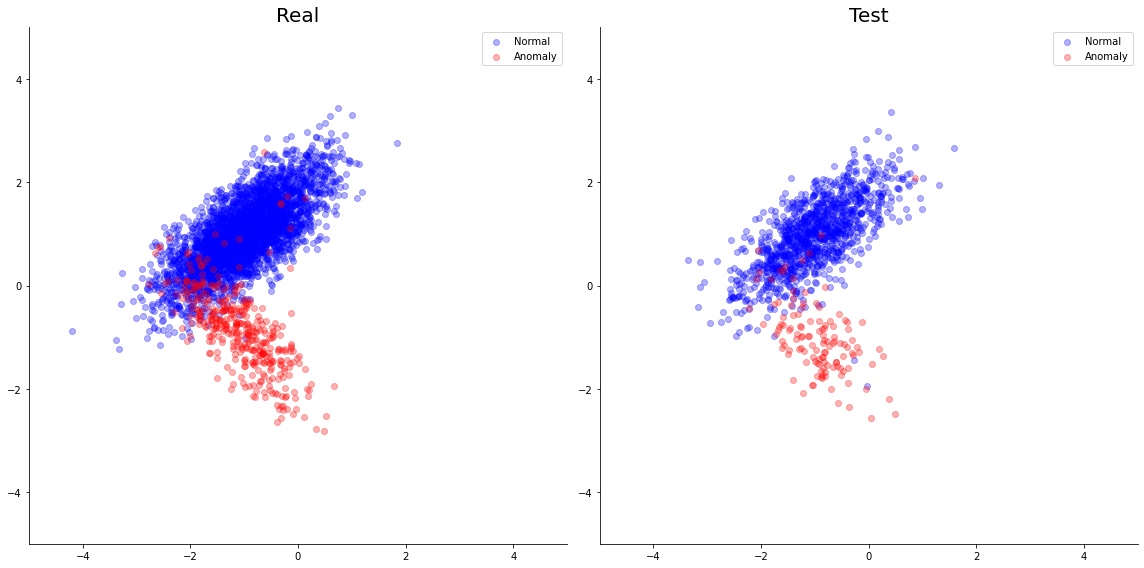

In [10]:
plot_representation(X_train, y_train, X_test, y_test, method='Test')

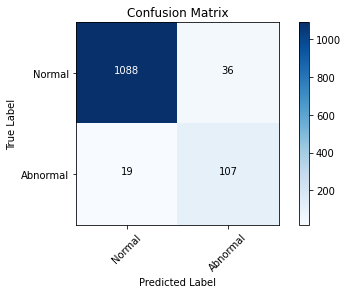

Accuracy : 0.9560
Precision : 0.8655
Recall : 0.9086
F1-score : 0.8854


In [11]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## 'Imblearn' package

### Random Under Sampling(RUS)

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler

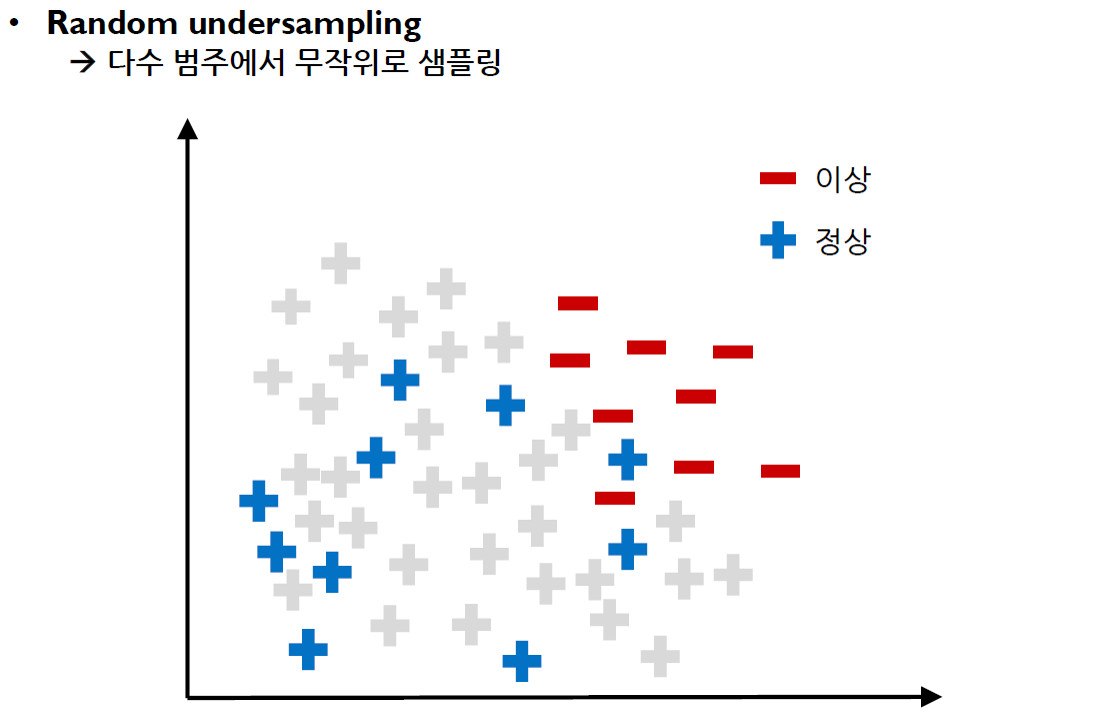

In [12]:
Image.open('./imgs/img1.png')

In [13]:
from imblearn.under_sampling import RandomUnderSampler

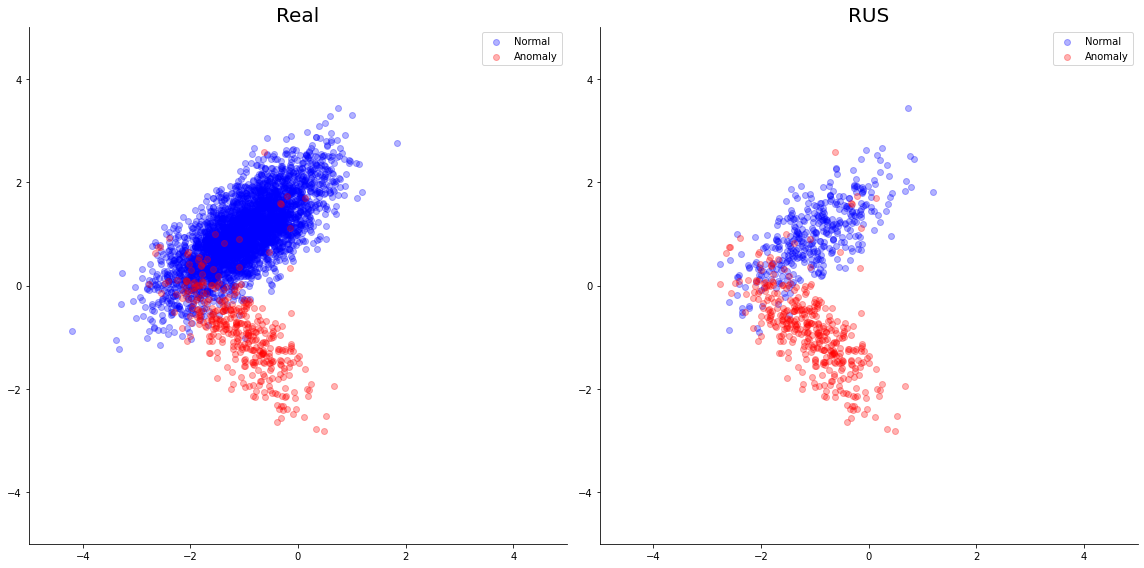

In [14]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=2023,
                         replacement=False)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'RUS')

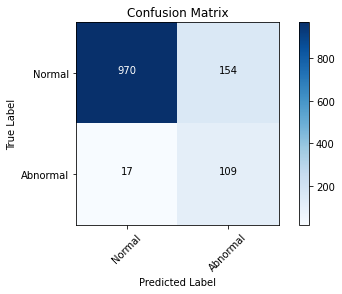

Accuracy : 0.8632
Precision : 0.6986
Recall : 0.8640
F1-score : 0.7397


In [15]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
rus_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = rus_tree.predict(X_test)
cm_rus = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_rus, classes)
_, _, _, f1_rus = calculate_classification_metrics(y_test, y_pred_test)

### TomekLinks

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html#imblearn.under_sampling.TomekLinks

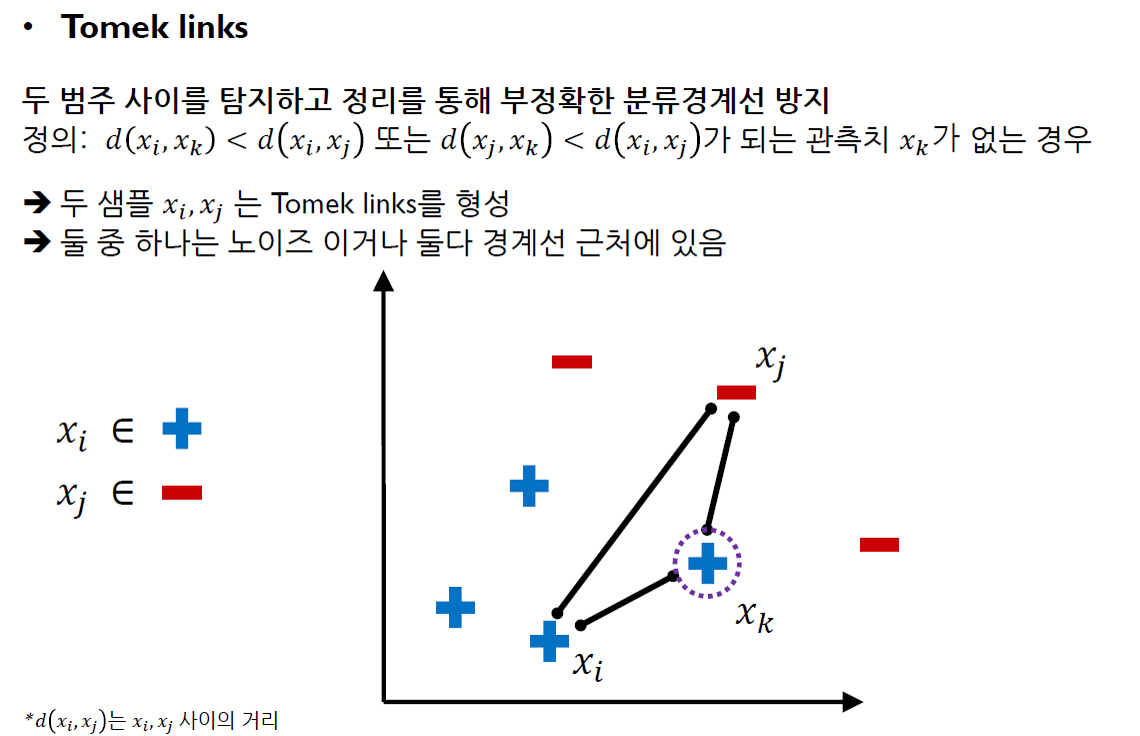

In [16]:
Image.open('./imgs/img2.png')

In [17]:
from imblearn.under_sampling import TomekLinks

(3750, 2) (3697, 2)


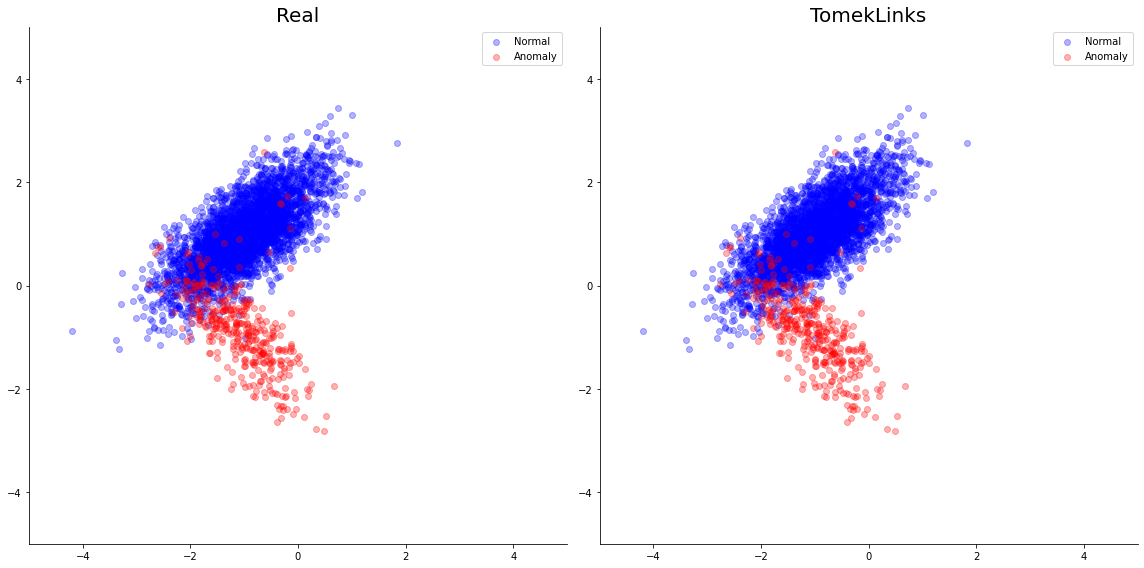

In [18]:
tl = TomekLinks(sampling_strategy='auto') # 다수 클래스만 제거 / if 'all' 모든 클래스 제거
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

print(X_train.shape, X_resampled.shape)
plot_representation(X_train, y_train, X_resampled, y_resampled, 'TomekLinks')

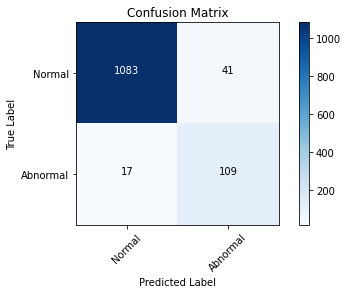

Accuracy : 0.9536
Precision : 0.8556
Recall : 0.9143
F1-score : 0.8819


In [19]:
tl_tree = tree.DecisionTreeClassifier(random_state=2023)
tl_tree = tl_tree.fit(X_resampled, y_resampled)

y_pred_test = tl_tree.predict(X_test)
cm_tl = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_tl, classes)
_, _, _, f1_tl = calculate_classification_metrics(y_test, y_pred_test)

In [20]:
iters = 10
n = X_train.shape[0]
for i in range(iters):
    if i == 0:
        tl = TomekLinks(sampling_strategy='auto')
        X_resampled, y_resampled = tl.fit_resample(X_train, y_train)
        
    else:
        tl = TomekLinks(sampling_strategy='auto')
        X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled)
    
    if n == X_resampled.shape[0]:
        print(f'{i+1} | number of samples after tomek sampling : {n}')
        break
    print(f'{i+1} | number of samples after tomek sampling : {n}')
    n = X_resampled.shape[0]
    

1 | number of samples after tomek sampling : 3750
2 | number of samples after tomek sampling : 3697
3 | number of samples after tomek sampling : 3682
4 | number of samples after tomek sampling : 3677
5 | number of samples after tomek sampling : 3676


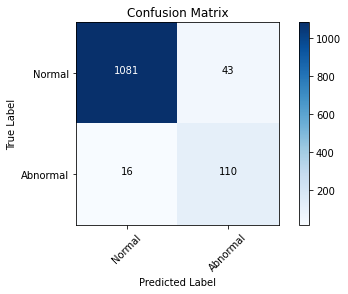

Accuracy : 0.9528
Precision : 0.8522
Recall : 0.9174
F1-score : 0.8810


In [21]:
tl_tree = tree.DecisionTreeClassifier(random_state=2023)
tl_tree = tl_tree.fit(X_resampled, y_resampled)

y_pred_test = tl_tree.predict(X_test)
cm_tl = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_tl, classes)
_, _, _, f1_tl = calculate_classification_metrics(y_test, y_pred_test)

### Condensed Nearest Neighbor

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.CondensedNearestNeighbour.html#imblearn.under_sampling.CondensedNearestNeighbour

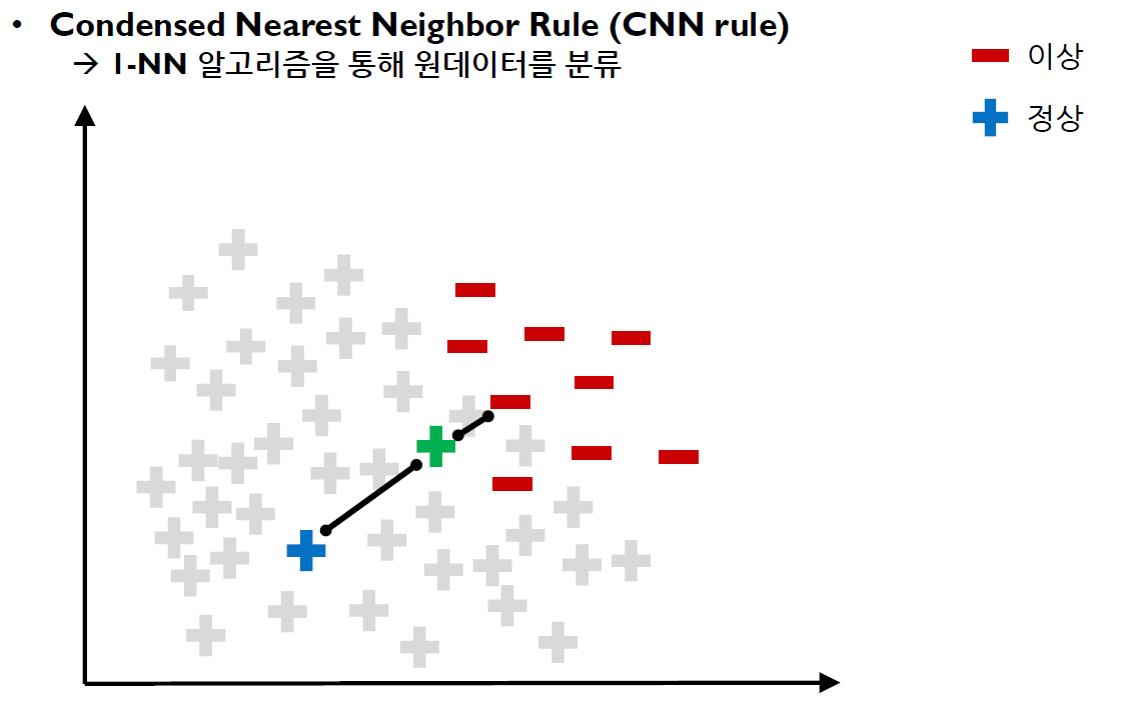

In [22]:
Image.open('./imgs/img3.png')

In [23]:
from imblearn.under_sampling import CondensedNearestNeighbour

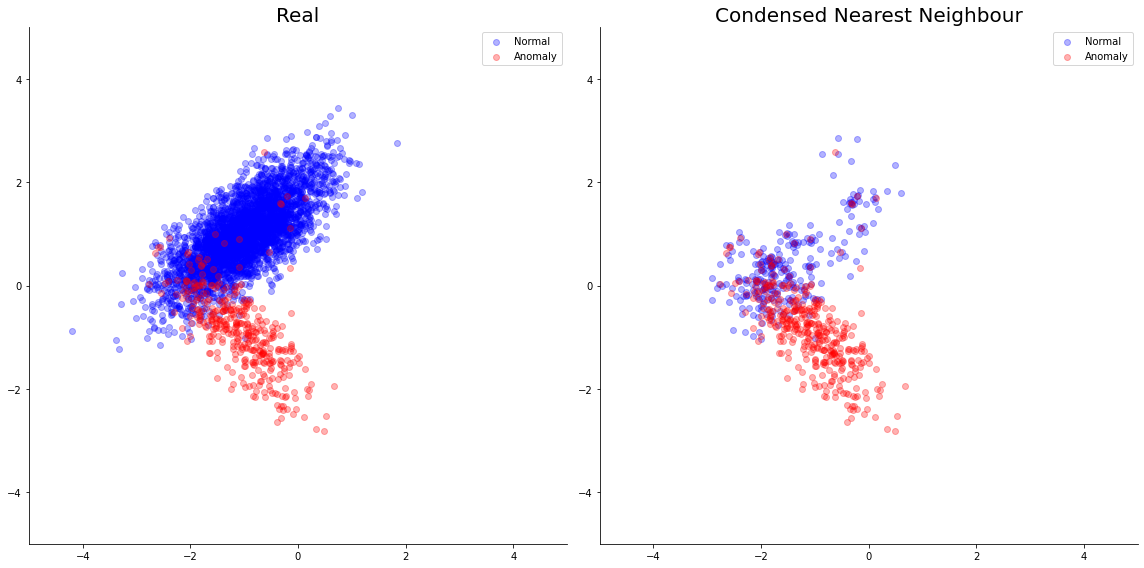

In [24]:
cnn = CondensedNearestNeighbour(sampling_strategy='auto',
                                random_state=2023)
X_resampled, y_resampled = cnn.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'Condensed Nearest Neighbour')

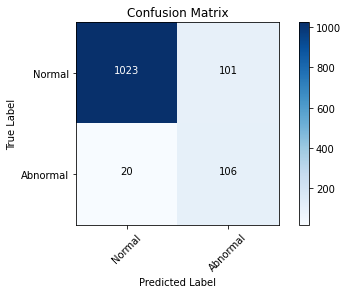

Accuracy : 0.9032
Precision : 0.7465
Recall : 0.8757
F1-score : 0.7904


In [25]:
cnn_tree = tree.DecisionTreeClassifier(random_state=2023)
cnn_tree = cnn_tree.fit(X_resampled, y_resampled)

y_pred_test = cnn_tree.predict(X_test)
cm_cnn = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm_cnn, classes)
_, _, _, f1_cnn = calculate_classification_metrics(y_test, y_pred_test)

### One-sided selection

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection

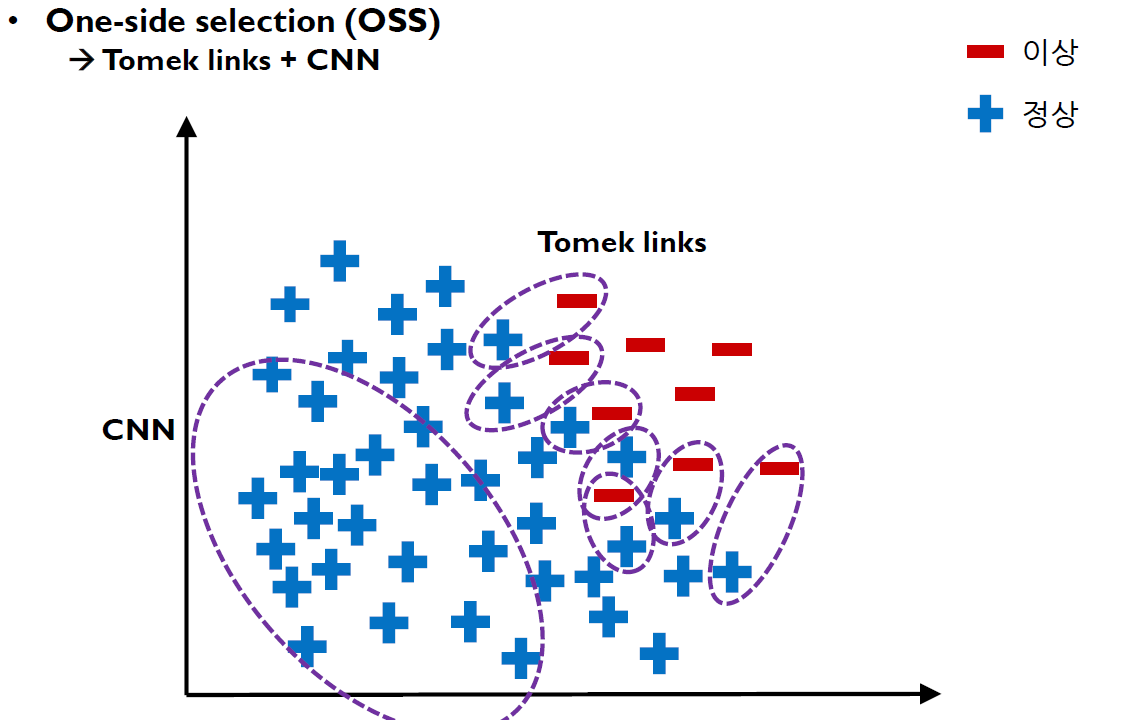

In [26]:
Image.open('./imgs/img4.png')

In [27]:
from imblearn.under_sampling import OneSidedSelection

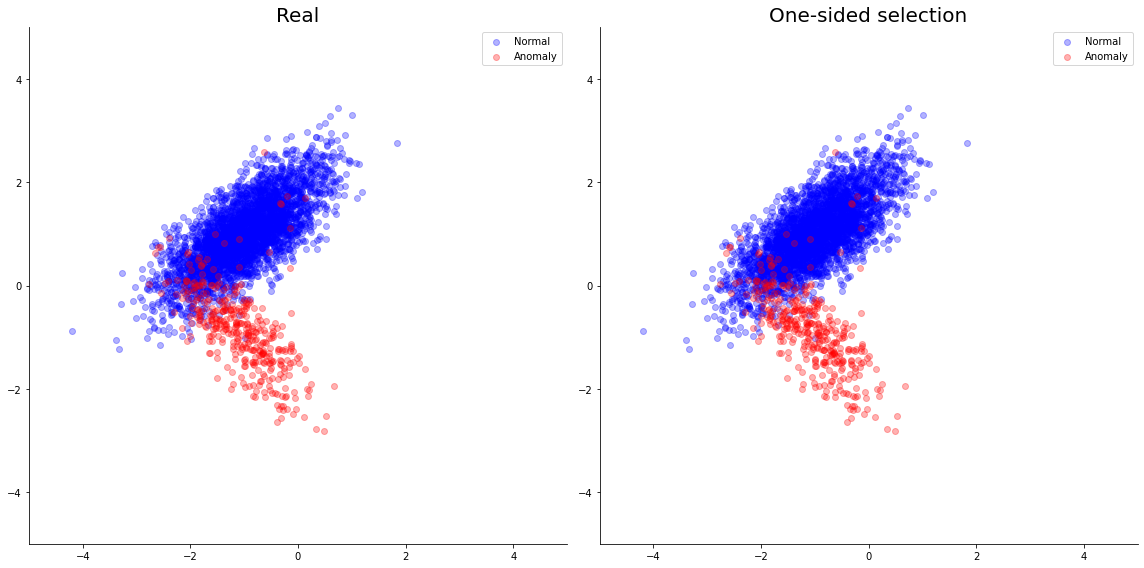

In [28]:
oss = OneSidedSelection(sampling_strategy='auto',
                        random_state=2023)
X_resampled, y_resampled = oss.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'One-sided selection')

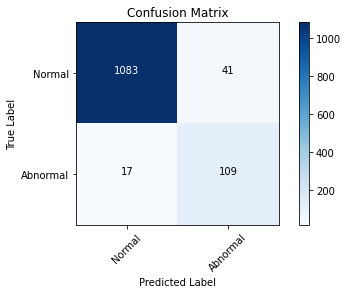

Accuracy : 0.9536
Precision : 0.8556
Recall : 0.9143
F1-score : 0.8819


In [29]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
oss_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = oss_tree.predict(X_test)
cm_oss = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm_oss, classes)
_, _, _, f1_oss = calculate_classification_metrics(y_test, y_pred_test)

<AxesSubplot:>

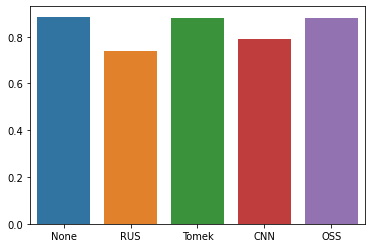

In [30]:
sns.barplot(x=['None','RUS','Tomek','CNN','OSS'],y=[f1_baseline,f1_rus,f1_tl,f1_cnn,f1_oss])


## Multi-Class Classification 문제 Undersampling

샘플 데이터 만들기 : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [31]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly1, y_anomaly2 = y[y==0].dropna(), y[y==1].dropna(), y[y==2].dropna()
    X_normal, X_anomaly1 = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly1.index), :]
    X_anomaly2 = X.loc[list(y_anomaly2.index), :]
    
    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly1['X1'], X_anomaly1['X2'], alpha=0.3, c='red', label='Abnormal1')
    ax1.scatter(X_anomaly2['X1'], X_anomaly2['X2'], alpha=0.3, c='green', label='Abnormal2') ## 추가된 부분
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly1, y_syn_anomaly2 = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna(), y_syn[y_syn==2].dropna()
        X_syn_normal, X_syn_anomaly1 = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly1.index), :]
        X_syn_anomaly2 = X_syn.loc[list(y_syn_anomaly2.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly1['X1'], X_syn_anomaly1['X2'], alpha=0.3, c='red', label='Abnormal1')
        ax2.scatter(X_syn_anomaly2['X1'], X_syn_anomaly2['X2'], alpha=0.3, c='green', label='Abnormal2') ## 추가된 부분

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)
        
    plt.show()

In [32]:
X_syn, y_syn = create_dataset(n_samples=5000, weights=(0.8, 0.1, 0.1), n_classes=3, n_cluster=1, random_state=711)
print(X_syn.shape, y_syn.shape)

(5000, 2) (5000, 1)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_syn,y_syn, random_state=2023)
print(y_train.value_counts())
print(y_test.value_counts())

y
0    2964
1     397
2     389
dtype: int64
y
0    1005
2     123
1     122
dtype: int64


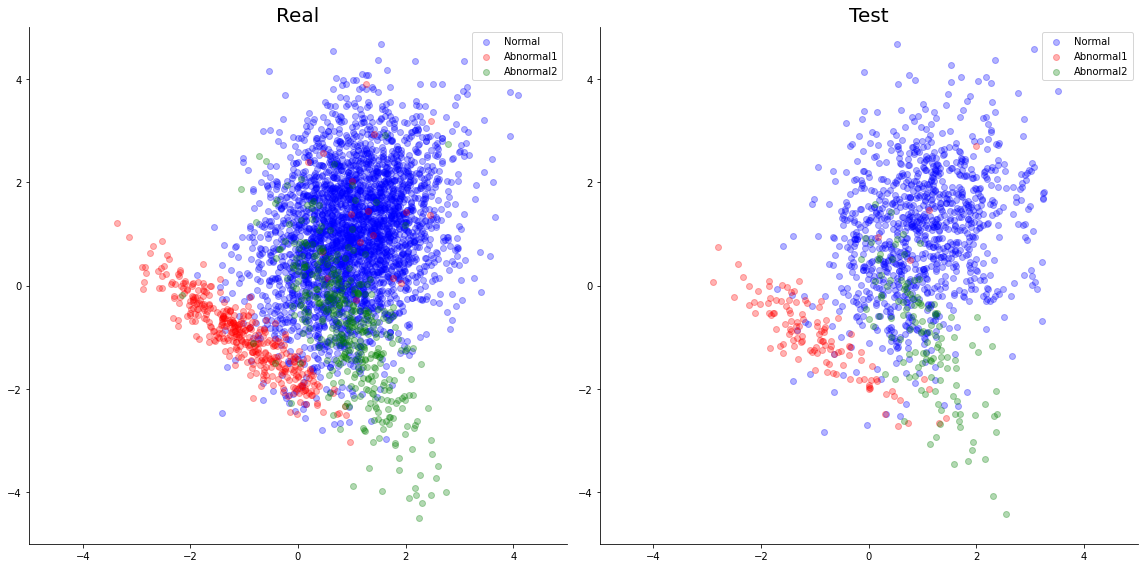

In [34]:
plot_representation(X_train, y_train, X_test, y_test, method='Test')

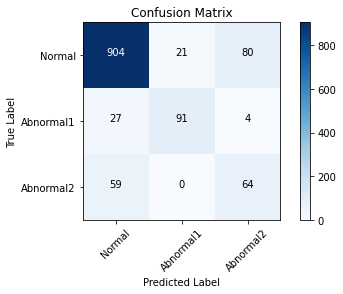

Accuracy : 0.8472
Precision : 0.7194
Recall : 0.7219
F1-score : 0.7188


In [35]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal1','Abnormal2']

plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## UnderSampling

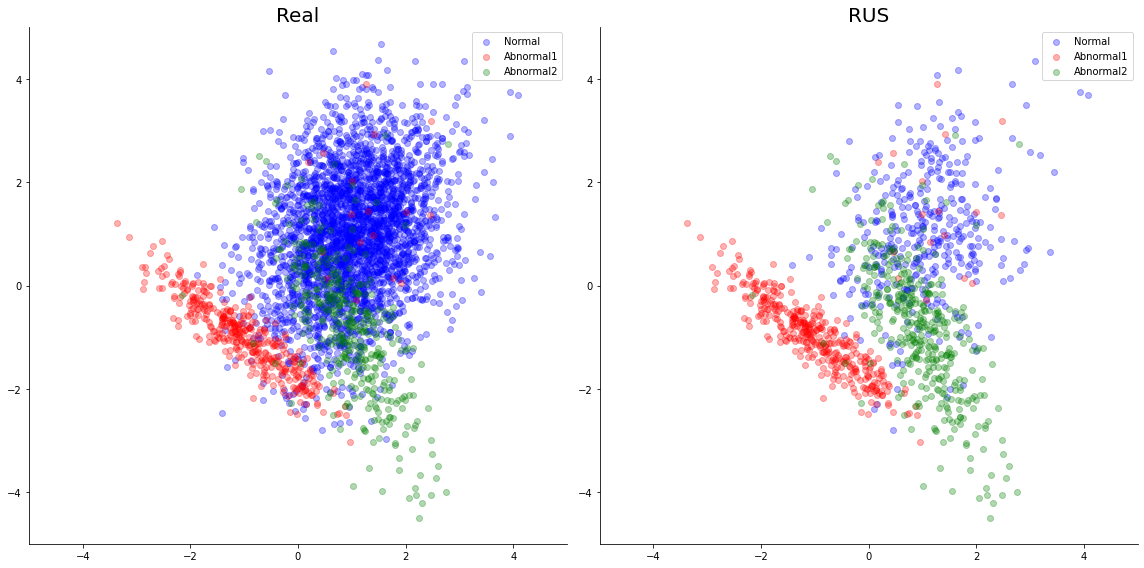

In [36]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=2023,
                         replacement=False)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'RUS')

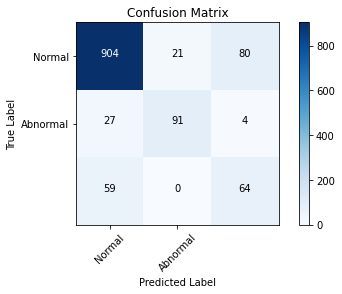

Accuracy : 0.8472
Precision : 0.7194
Recall : 0.7219
F1-score : 0.7188


In [37]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

## Tomek's Links

(3750, 2) (3523, 2)


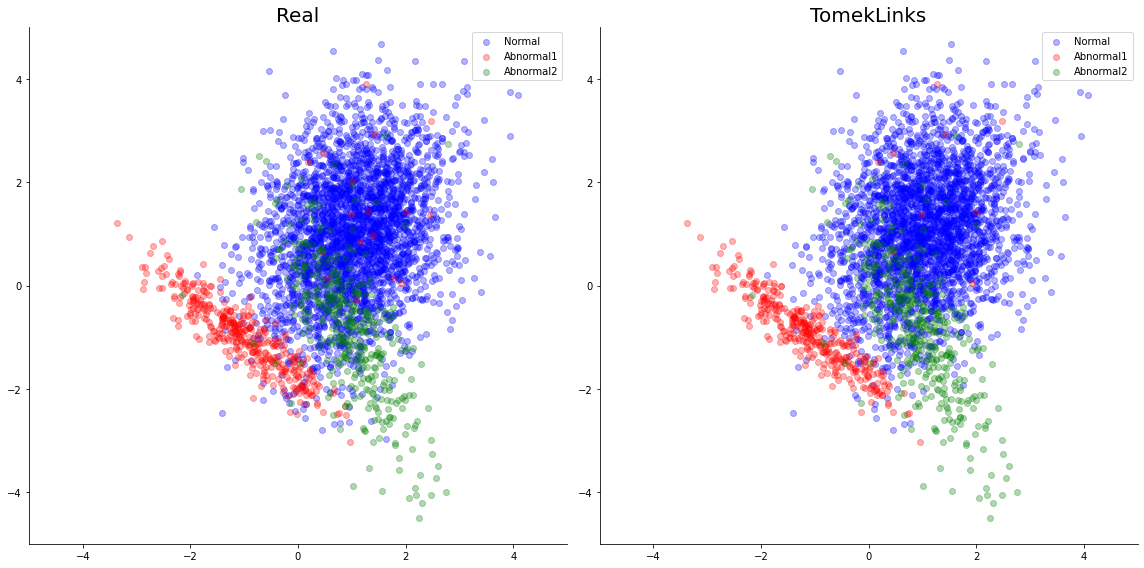

In [38]:
tl = TomekLinks(sampling_strategy='auto')
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

print(X_train.shape, X_resampled.shape)
plot_representation(X_train, y_train, X_resampled, y_resampled, 'TomekLinks')

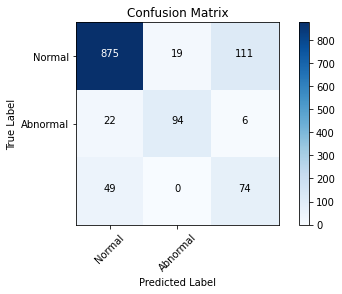

Accuracy : 0.8344
Precision : 0.7147
Recall : 0.7476
F1-score : 0.7228


In [39]:
tl_tree = tree.DecisionTreeClassifier(random_state=2023)
tl_tree = tl_tree.fit(X_resampled, y_resampled)

y_pred_test = tl_tree.predict(X_test)
cm_tl = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_tl, classes)
_, _, _, f1_tl = calculate_classification_metrics(y_test, y_pred_test)

## CNN

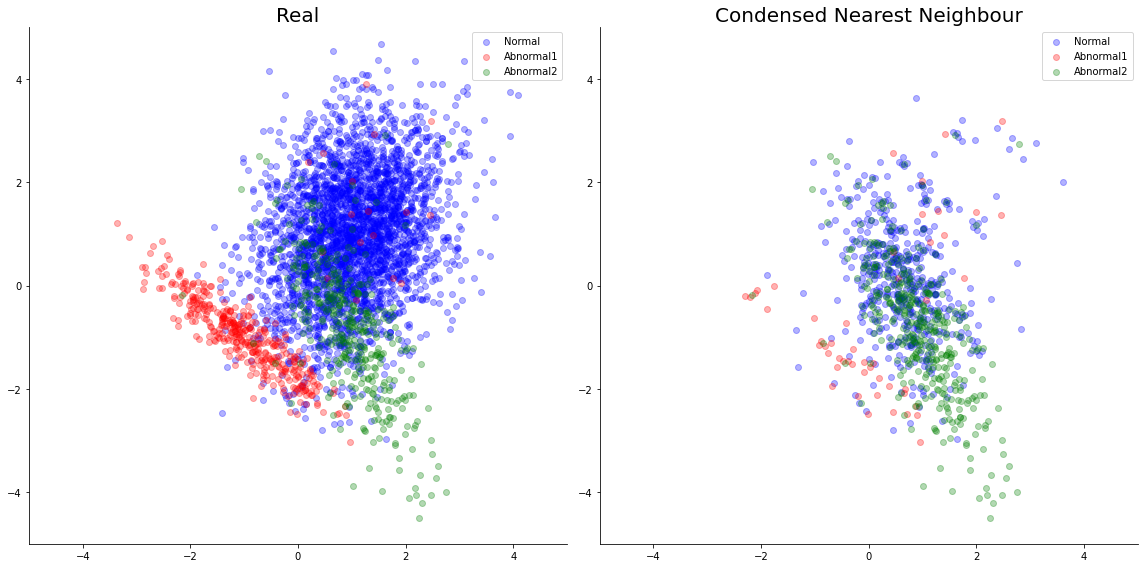

In [40]:
cnn = CondensedNearestNeighbour(sampling_strategy='auto',
                                random_state=2023)
X_resampled, y_resampled = cnn.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'Condensed Nearest Neighbour')

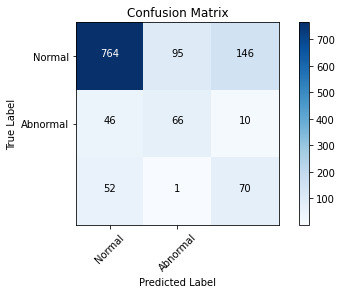

Accuracy : 0.7200
Precision : 0.5345
Recall : 0.6234
F1-score : 0.5615


In [41]:
cnn_tree = tree.DecisionTreeClassifier(random_state=2023)
cnn_tree = cnn_tree.fit(X_resampled, y_resampled)

y_pred_test = cnn_tree.predict(X_test)
cm_cnn = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm_cnn, classes)
_, _, _, f1_cnn = calculate_classification_metrics(y_test, y_pred_test)

## OSS

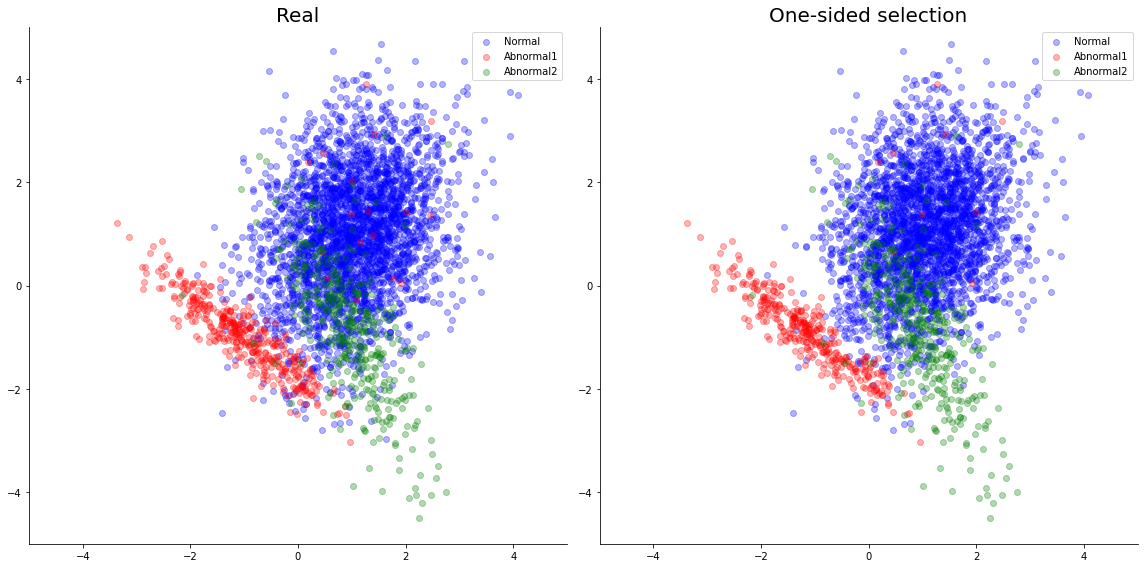

In [42]:
oss = OneSidedSelection(sampling_strategy='auto',
                        random_state=2023)
X_resampled, y_resampled = oss.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'One-sided selection')

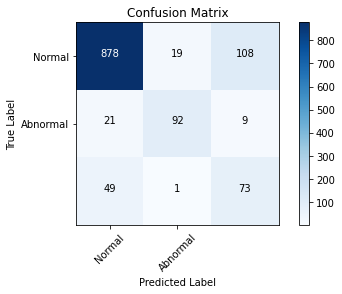

Accuracy : 0.8344
Precision : 0.7106
Recall : 0.7404
F1-score : 0.7173


In [43]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
oss_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = oss_tree.predict(X_test)
cm_oss = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm_oss, classes)
_, _, _, f1_oss = calculate_classification_metrics(y_test, y_pred_test)

<AxesSubplot:>

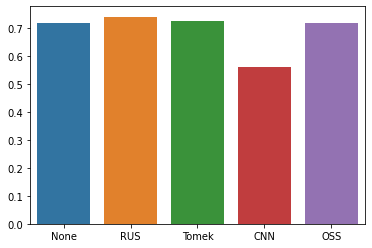

In [44]:
sns.barplot(x=['None','RUS','Tomek','CNN','OSS'],y=[f1_baseline,f1_rus,f1_tl,f1_cnn,f1_oss])